
Based off of the statsmodels documentation:

https://www.statsmodels.org/dev/examples/notebooks/generated/copula.html

https://www.statsmodels.org/stable/generated/statsmodels.distributions.copula.api.GaussianCopula.html


understanding implementing the student-t copula
https://en.wikipedia.org/wiki/Multivariate_t-distribution
https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics)


https://stats.stackexchange.com/questions/180875/appropriate-number-of-degrees-of-freedom-in-t-copula#:~:text=For%20instance%20a%20T%2DStudent,between%20the%20operational%20risk%20events.%E2%80%9D


good paper:
https://www.efmaefm.org/0EFMAMEETINGS/EFMA%20ANNUAL%20MEETINGS/2014-Rome/papers/EFMA2014_0222_FullPaper.pdf

In [205]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import sys
import scipy.stats as stats
import matplotlib.image as mpimg

from matplotlib.pyplot import contourf

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula)

from scipy.optimize import minimize
from scipy.integrate import quad

# just set the seed for the random number generator
np.random.seed(42)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt


from statsmodels.distributions.copula.api import (FrankCopula, ClaytonCopula, GumbelCopula, GaussianCopula, StudentTCopula, ExtremeValueCopula, IndependenceCopula)
from statsmodels.tools.eval_measures import aic

In [89]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

In [90]:
# importing and formatting data to be readable from a list of top 50 asx mining companies 
df = pd.read_csv('mining_stocks.txt', sep='\t')
codes = df.drop(columns=['0.','Company','Market Cap', 'Share Price', '.91', '%_Change'])
stocks = list(codes['Code'])
stocks = [stock[4:] for stock in stocks]

stocks[0:10]

['BHP', 'FMG', 'RIO', 'NCM', 'JHX', 'S32', 'PLS', 'MIN', 'NST', 'AMC']

In [91]:
#fixing error
import yfinance as yfin
yfin.pdr_override()

end = dt.datetime(2023, 1, 1)
start = dt.datetime(2013,1,1)

stocksax = [stock + '.AX' for stock in stocks]

data = get_data(stocksax, start, end)
# drop all columns with nan values
data = data.dropna(axis=1)
data.head()

[*********************100%%**********************]  50 of 50 completed


A4N.AX  ABC.AX    AKE.AX    AMC.AX    AVZ.AX  AWC.AX    AZS.AX  \
Date                                                                           
2013-01-02  0.034909    3.12  1.593411  7.317752  0.020843   0.930  0.358340   
2013-01-03  0.034909    3.20  1.583452  7.398561  0.020843   0.950  0.378248   
2013-01-04  0.033939    3.20  1.568514  7.371625  0.020843   0.950  0.358340   
2013-01-07  0.033939    3.19  1.493823  7.371625  0.020843   0.955  0.358340   
2013-01-08  0.030060    3.26  1.478884  7.452434  0.020843   0.980  1.274100   

              BGL.AX     BHP.AX  BKW.AX  ...  PLS.AX    PRU.AX     RIO.AX  \
Date                                     ...                                
2013-01-02  0.086326  35.359264   11.60  ...   0.029  2.087932  67.620003   
2013-01-03  0.087244  35.648941   11.67  ...   0.029  2.176991  69.250000   
2013-01-04  0.087244  35.424675   11.80  ...   0.029  2.127514  68.550003   
2013-01-07  0.087244  35.331230   11.85  ...   0.029  2.087932  67.400002   
2013-01-08  0.087244  35.041553   11.90  ...   0.029  2.058246  66.599998   

              RMS.AX  RRL.AX  SFR.AX  SGM.AX    SMR.AX    SYA.AX  ZIM.AX  
Date                                                                      
2013-01-02  0.458252    5.23    8.80    9.57  0.194117  0.162577     8.5  
2013-01-03  0.468214    5.33    8.94    9.86  0.184411  0.162577     8.5  
2013-01-04  0.453271    5.11    8.82    9.59  0.184411  0.162577     8.6  
2013-01-07  0.458252    4.99    8.74    9.67  0.189264  0.162577     8.6  
2013-01-08  0.473195    5.05    8.63    9.52  0.184411  0.162577     8.7  

[5 rows x 43 columns]

# Testing

make a for loop to evaluate the AIC score of a dictionary of copulas

find a way to get the mispricing index

make a nice version of this and comment it well

In [92]:
### Getting AIC score

S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))[1:]
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))[1:]

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T
u[u == 1] = 0.9999999999999999 # to stop getting a -inf

theta = ClaytonCopula().fit_corr_param(u)

copula = GumbelCopula(theta)
# _ = copula.plot_pdf()

# AIC score 2k - 2ln(L)
AIC = 2 - 2*(copula.logpdf(u=u)).sum()
AIC

# sum(copula.logpdf(u=u))

# aic(sum(copula.pdf(u=u)), 1, 1)
# sum(np.log(copula.pdf(u=u[u != 0])))
# np.where(m == -np.inf)

-2120.6941271810406

In [190]:

#? get the mispricing index
#* evaluate AIC in a for loop
#? put into function for trading

# Creating the dictionary

In [93]:
### setup the dictionary

# FrankCopula, ClaytonCopula, GumbelCopula, GaussianCopula, StudentTCopula, ExtremeValueCopula, IndependenceCopula
copulas = ["FrankCopula", "ClaytonCopula", "GumbelCopula", "GaussianCopula", "StudentTCopula"]
families = {}
Copula = {"copula":FrankCopula(),
          "AIC":np.inf}

# create dictionary for copula
for name in copulas:
    dictionary = {"c":eval(name),
                 "AIC":np.inf}
    families[name] = dictionary

# update the copulas with values

# get the key for the smallest AIC value
#out = [key for key in families.keys() if [min(families[key]["AIC"] for key in families.keys())][0] == families[key]["AIC"]][0]
#out

## Update the parameters of the copulas

In [94]:
### Update the parameters of the functions in the dictionary

S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))[1:]
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))[1:]

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]
# one array
uv = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T
uv[uv == 1] = 0.9999999999999999 # to stop getting a -inf

# update the parameters
for name in families.keys():
    root = families[name]['c']

    if name == "StudentTCopula": # this copula required degrees of freedom (recommended as 3-4)
        param = eval(name)().fit_corr_param(uv)
        families[name]['c'] = eval(name)(param, df=4)
    else:
        param = eval(name)().fit_corr_param(uv)
        families[name]['c'] = eval(name)(param)
    
    # if name in ['GaussianCopula', "StudentTCopula"]:
    #     print(f"{name}: corr matrix")
    #     corr = np.corrcoef(u, v)
    #     families[name]['c'] = eval(name)(corr)
    # else:
    #     print(f"{name}: theta")
    #     theta = eval(name)().fit_corr_param(uv)
    #     families[name]['c'] = eval(name)(theta)
    #     # instead pass through a correlation matrix
families


{'FrankCopula': {'c': <statsmodels.distributions.copula.archimedean.FrankCopula at 0x157e31d00>,
  'AIC': inf},
 'ClaytonCopula': {'c': <statsmodels.distributions.copula.archimedean.ClaytonCopula at 0x157dd0af0>,
  'AIC': inf},
 'GumbelCopula': {'c': <statsmodels.distributions.copula.archimedean.GumbelCopula at 0x157fda640>,
  'AIC': inf},
 'GaussianCopula': {'c': <statsmodels.distributions.copula.elliptical.GaussianCopula at 0x153af4eb0>,
  'AIC': inf},
 'StudentTCopula': {'c': <statsmodels.distributions.copula.elliptical.StudentTCopula at 0x153af4d00>,
  'AIC': inf}}

## Plotting the copulas

FrankCopula (0, 0)
ClaytonCopula (1, 0)
GumbelCopula (2, 0)
GaussianCopula (0, 1)


/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/statsmodels/distributions/copula/copulas.py:463: UserWarning:

The figure layout has changed to tight



StudentTCopula (1, 1)
pass (2, 1)


/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_2757/3767161227.py:40: UserWarning:

The figure layout has changed to tight



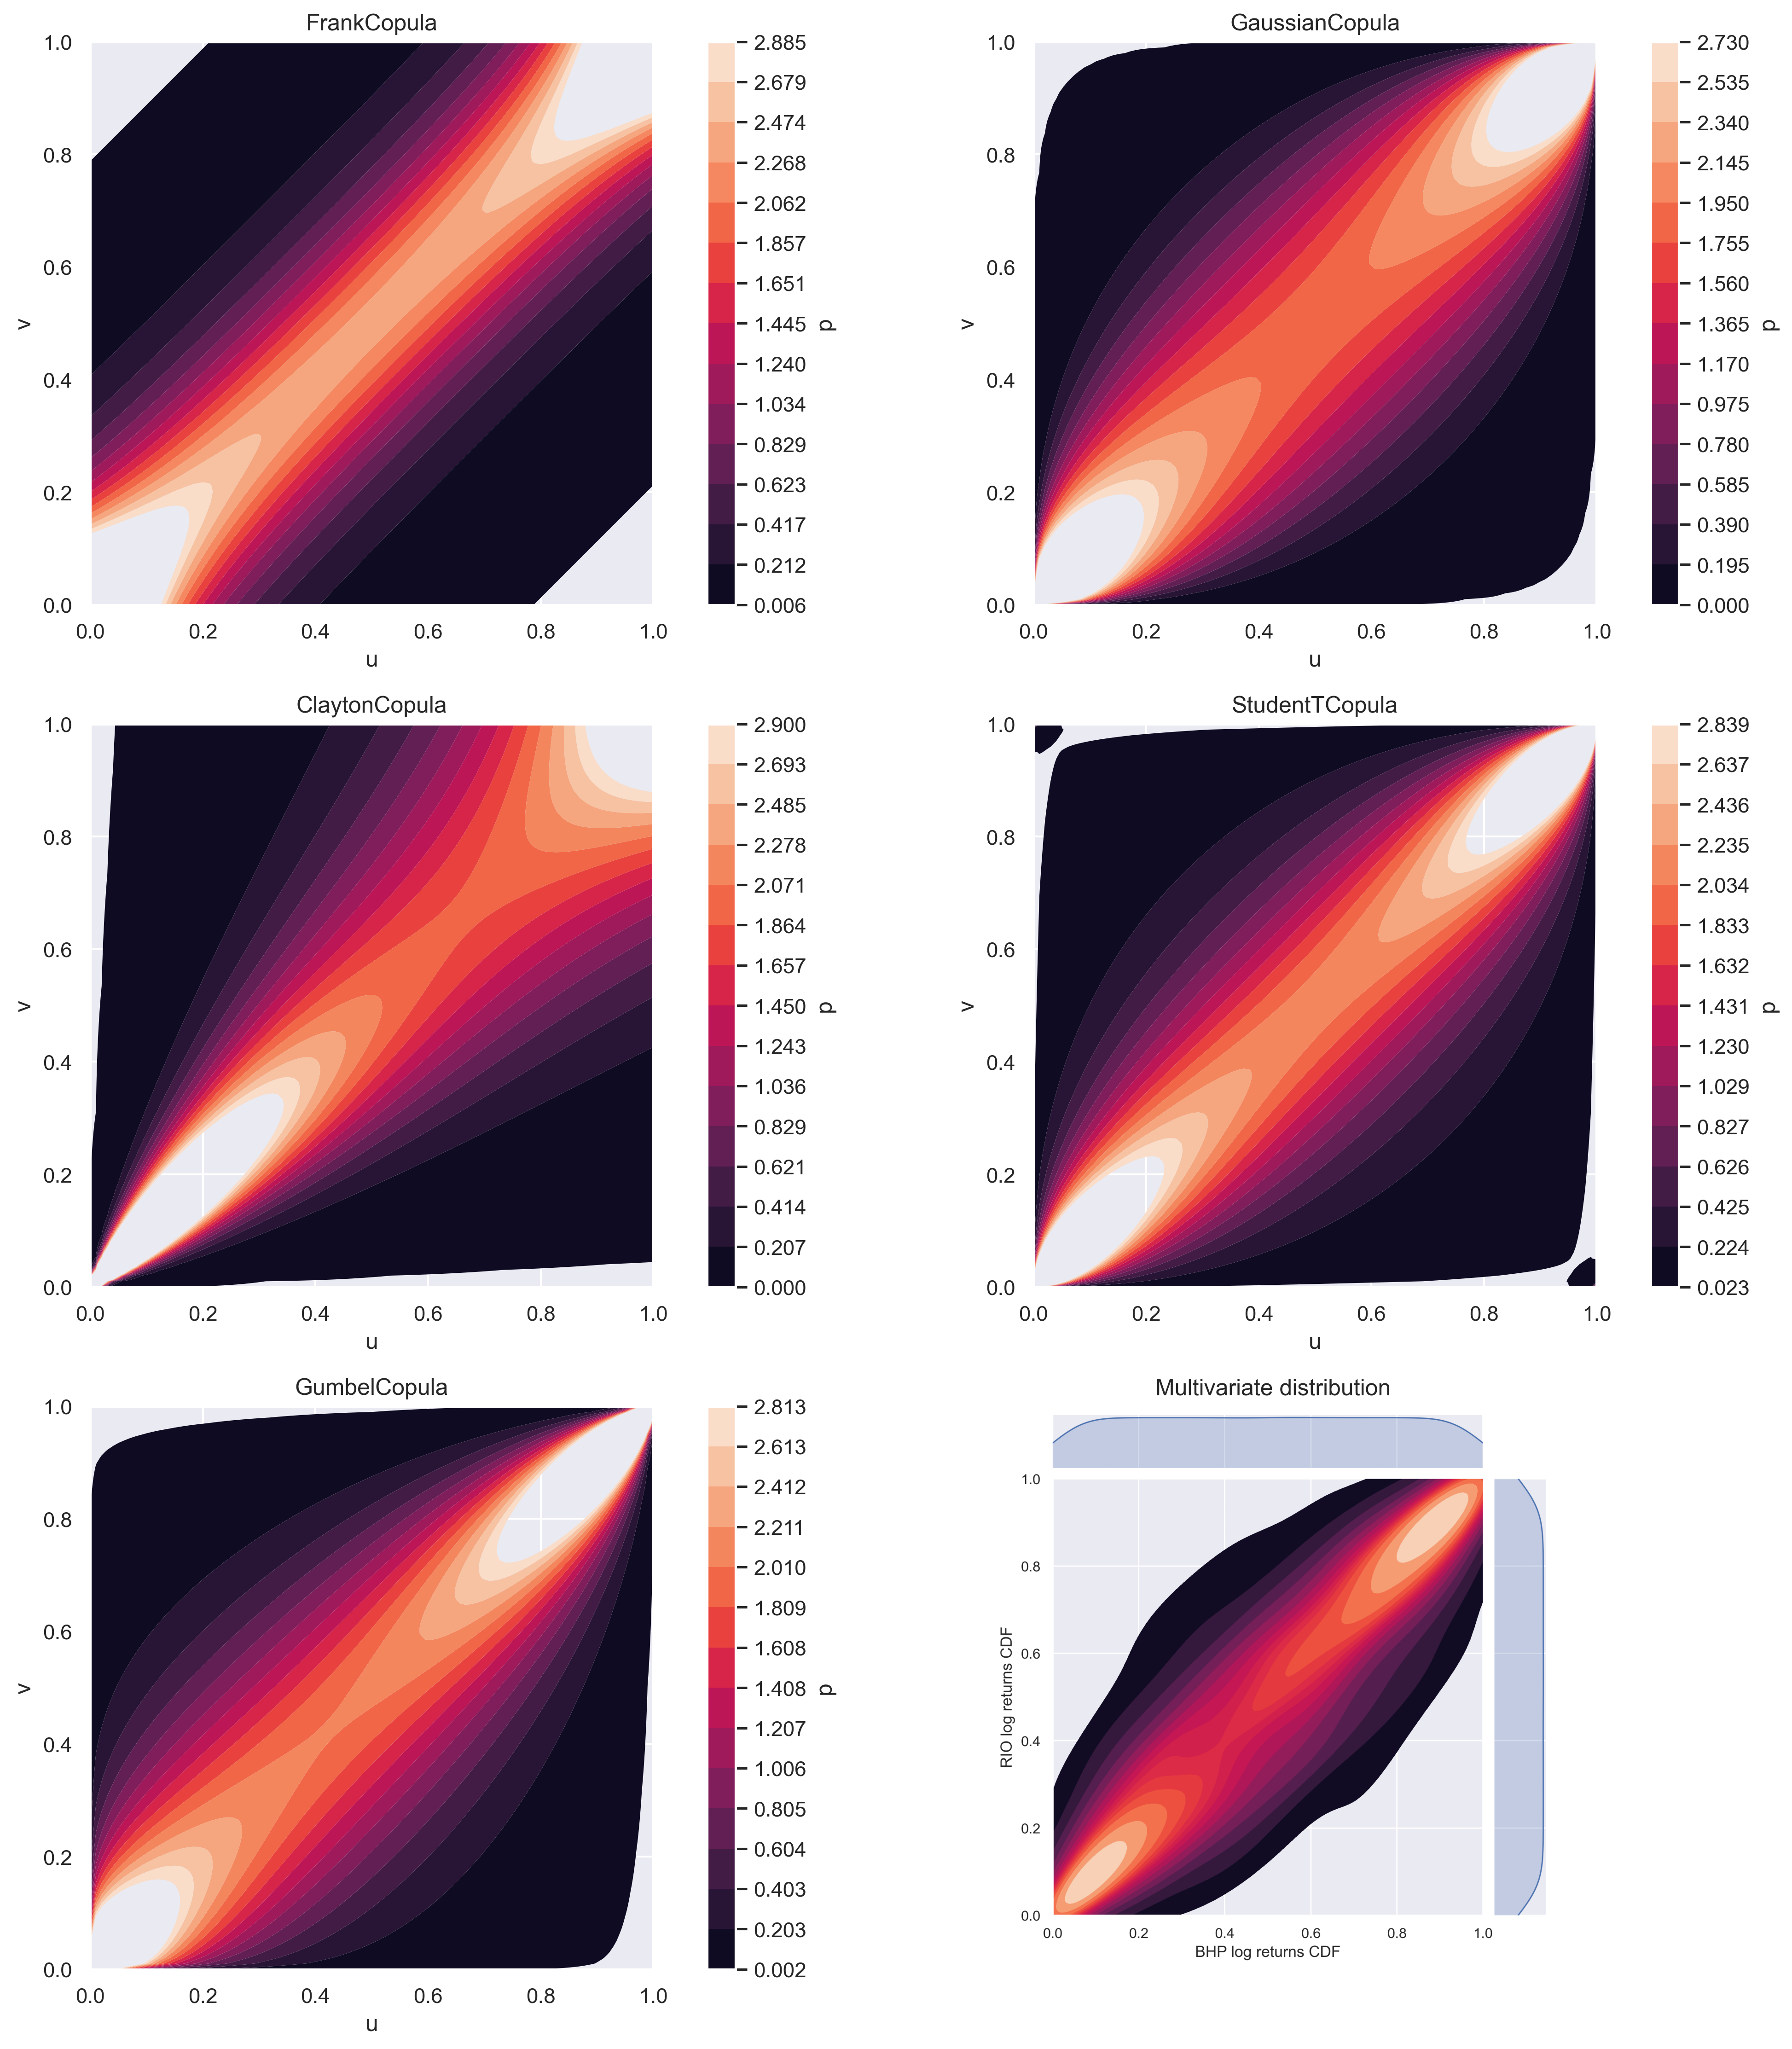

In [95]:
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot/47664533#47664533
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
# sns.set(rc={'figure.figsize':(15,15)})


#* set the overall heatmap to "rocket"

import numpy as np
seed = 42
rng = np.random.default_rng(seed)

#todo plot them on different subplots, plot them as scatter, plot the default u,v data

fig, axs = plt.subplots(3 ,2, figsize=(15, 15))
count = 1

lst = list(families.keys())

    # print(count, name)
count = 0
for c in range(2):
    for r in range(3):
        try:
            print(lst[count], (r,c))
            families[lst[count]]['c'].plot_pdf(ticks_nbr= 15,ax=axs[r,c], )
            axs[r,c].set_title(lst[count])
        except:
            print("pass", (r,c))
        count += 1
# seaborn plot
g = sns.jointplot(x=u, y=v, kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = g.set_axis_labels("BHP log returns CDF", "RIO log returns CDF")
# save in memory temporarily
g.savefig('g.png')
plt.close(g.fig)
axs[2,1].imshow(mpimg.imread('g.png'))
axs[2,1].set_title('Multivariate distribution')
plt.tight_layout()
plt.grid(False)
plt.axis('off')
# fig.suptitle('Archimedian and Elliptical copulas, and the ECDF multivariate distribution')
plt.savefig('copulas.png')

## Getting the AIC for each copula

In [96]:
### Update the parameters of the functions in the dictionary

S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))[1:]
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))[1:]

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]
# one array
uv = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T
uv[uv == 1] = 0.9999999999999999 # to stop getting a -inf

# update the parameters
for name in families.keys():
    copula = families[name]['c']
    # log pdf 
    logpdf = (copula.logpdf(u=uv)).sum()
    k = 1
    # calculate aic
    AIC = 2*k - 2*logpdf
    # update dict
    families[name]['AIC'] = AIC
families

{'FrankCopula': {'c': <statsmodels.distributions.copula.archimedean.FrankCopula at 0x157e31d00>,
  'AIC': -2941.0118073768904},
 'ClaytonCopula': {'c': <statsmodels.distributions.copula.archimedean.ClaytonCopula at 0x157dd0af0>,
  'AIC': -1968.1132131609934},
 'GumbelCopula': {'c': <statsmodels.distributions.copula.archimedean.GumbelCopula at 0x157fda640>,
  'AIC': -2678.8561614190894},
 'GaussianCopula': {'c': <statsmodels.distributions.copula.elliptical.GaussianCopula at 0x153af4eb0>,
  'AIC': -2852.9740303306935},
 'StudentTCopula': {'c': <statsmodels.distributions.copula.elliptical.StudentTCopula at 0x153af4d00>,
  'AIC': -3102.9730506364076}}

### Get the copula with the "best" AIC score

In [97]:
# get the key for the smallest AIC value
best_copula = [key for key in families.keys() if [min(families[key]["AIC"] for key in families.keys())][0] == families[key]["AIC"]][0]
best_copula

'StudentTCopula'

# Calculate the mispricing index

In [98]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))[1:]
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))[1:]

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]

copula = families['ClaytonCopula']['c']
# copula.ppfcond_2g1()

AttributeError: 'ClaytonCopula' object has no attribute 'ppfcond_2g1'

## Take a partial derivative

An introduction to copulas for proof of partial derivatives:


https://link.springer.com/book/10.1007/0-387-28678-0

paper: (pg. 12)

https://www.efmaefm.org/0EFMAMEETINGS/EFMA%20ANNUAL%20MEETINGS/2014-Rome/papers/EFMA2014_0222_FullPaper.pdf

tutorial:

https://www.tutorialspoint.com/how-to-compute-derivative-using-numpy#:~:text=To%20compute%20partial%20derivatives%2C%20all,each%20point%20in%20the%20domain.

In [99]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))[1:]
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))[1:]

# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]
uv = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T
#vu = np.array([[ecdf_y(a) for a in y], [ecdf_x(a) for a in x]]).T

#uv[uv == 1] = 0.9999999999999999 # to stop getting a -inf

copula = families['FrankCopula']['c']
function = copula.cdf(uv)
# Cumulative distribution function
MI_u_v = np.gradient(function, v)
MI_v_u = np.gradient(function, u)
MI_u_v, MI_v_u

(array([ 0.70718446,  0.69840002,  0.05019288, ...,  1.01263189,
        14.01042832, 13.74330632]),
 array([ 1.31443238, -1.4825319 , -1.71949172, ...,  1.03604953,
         0.32388705,  0.63565532]))

# Vine copula (Bicop) in module

vine copula is a better method for multivariate copulas (non bivariate)

`pip install pyvinecopulib`

In [53]:
import pyvinecopulib as pv

In [108]:
# dt = pv.Bicop(family=pv.BicopFamily.gaussian).simulate(n=1000)

# cop1 = pv.Bicop(data=uv)
# cop2 = pv.Bicop(data=dt)
# cop1, cop2

(<pyvinecopulib.Bicop>
 TLL, parameters = [30x30 grid],
 <pyvinecopulib.Bicop>
 Joe 90°, parameters = 1.02985)

-3157.9457951827562

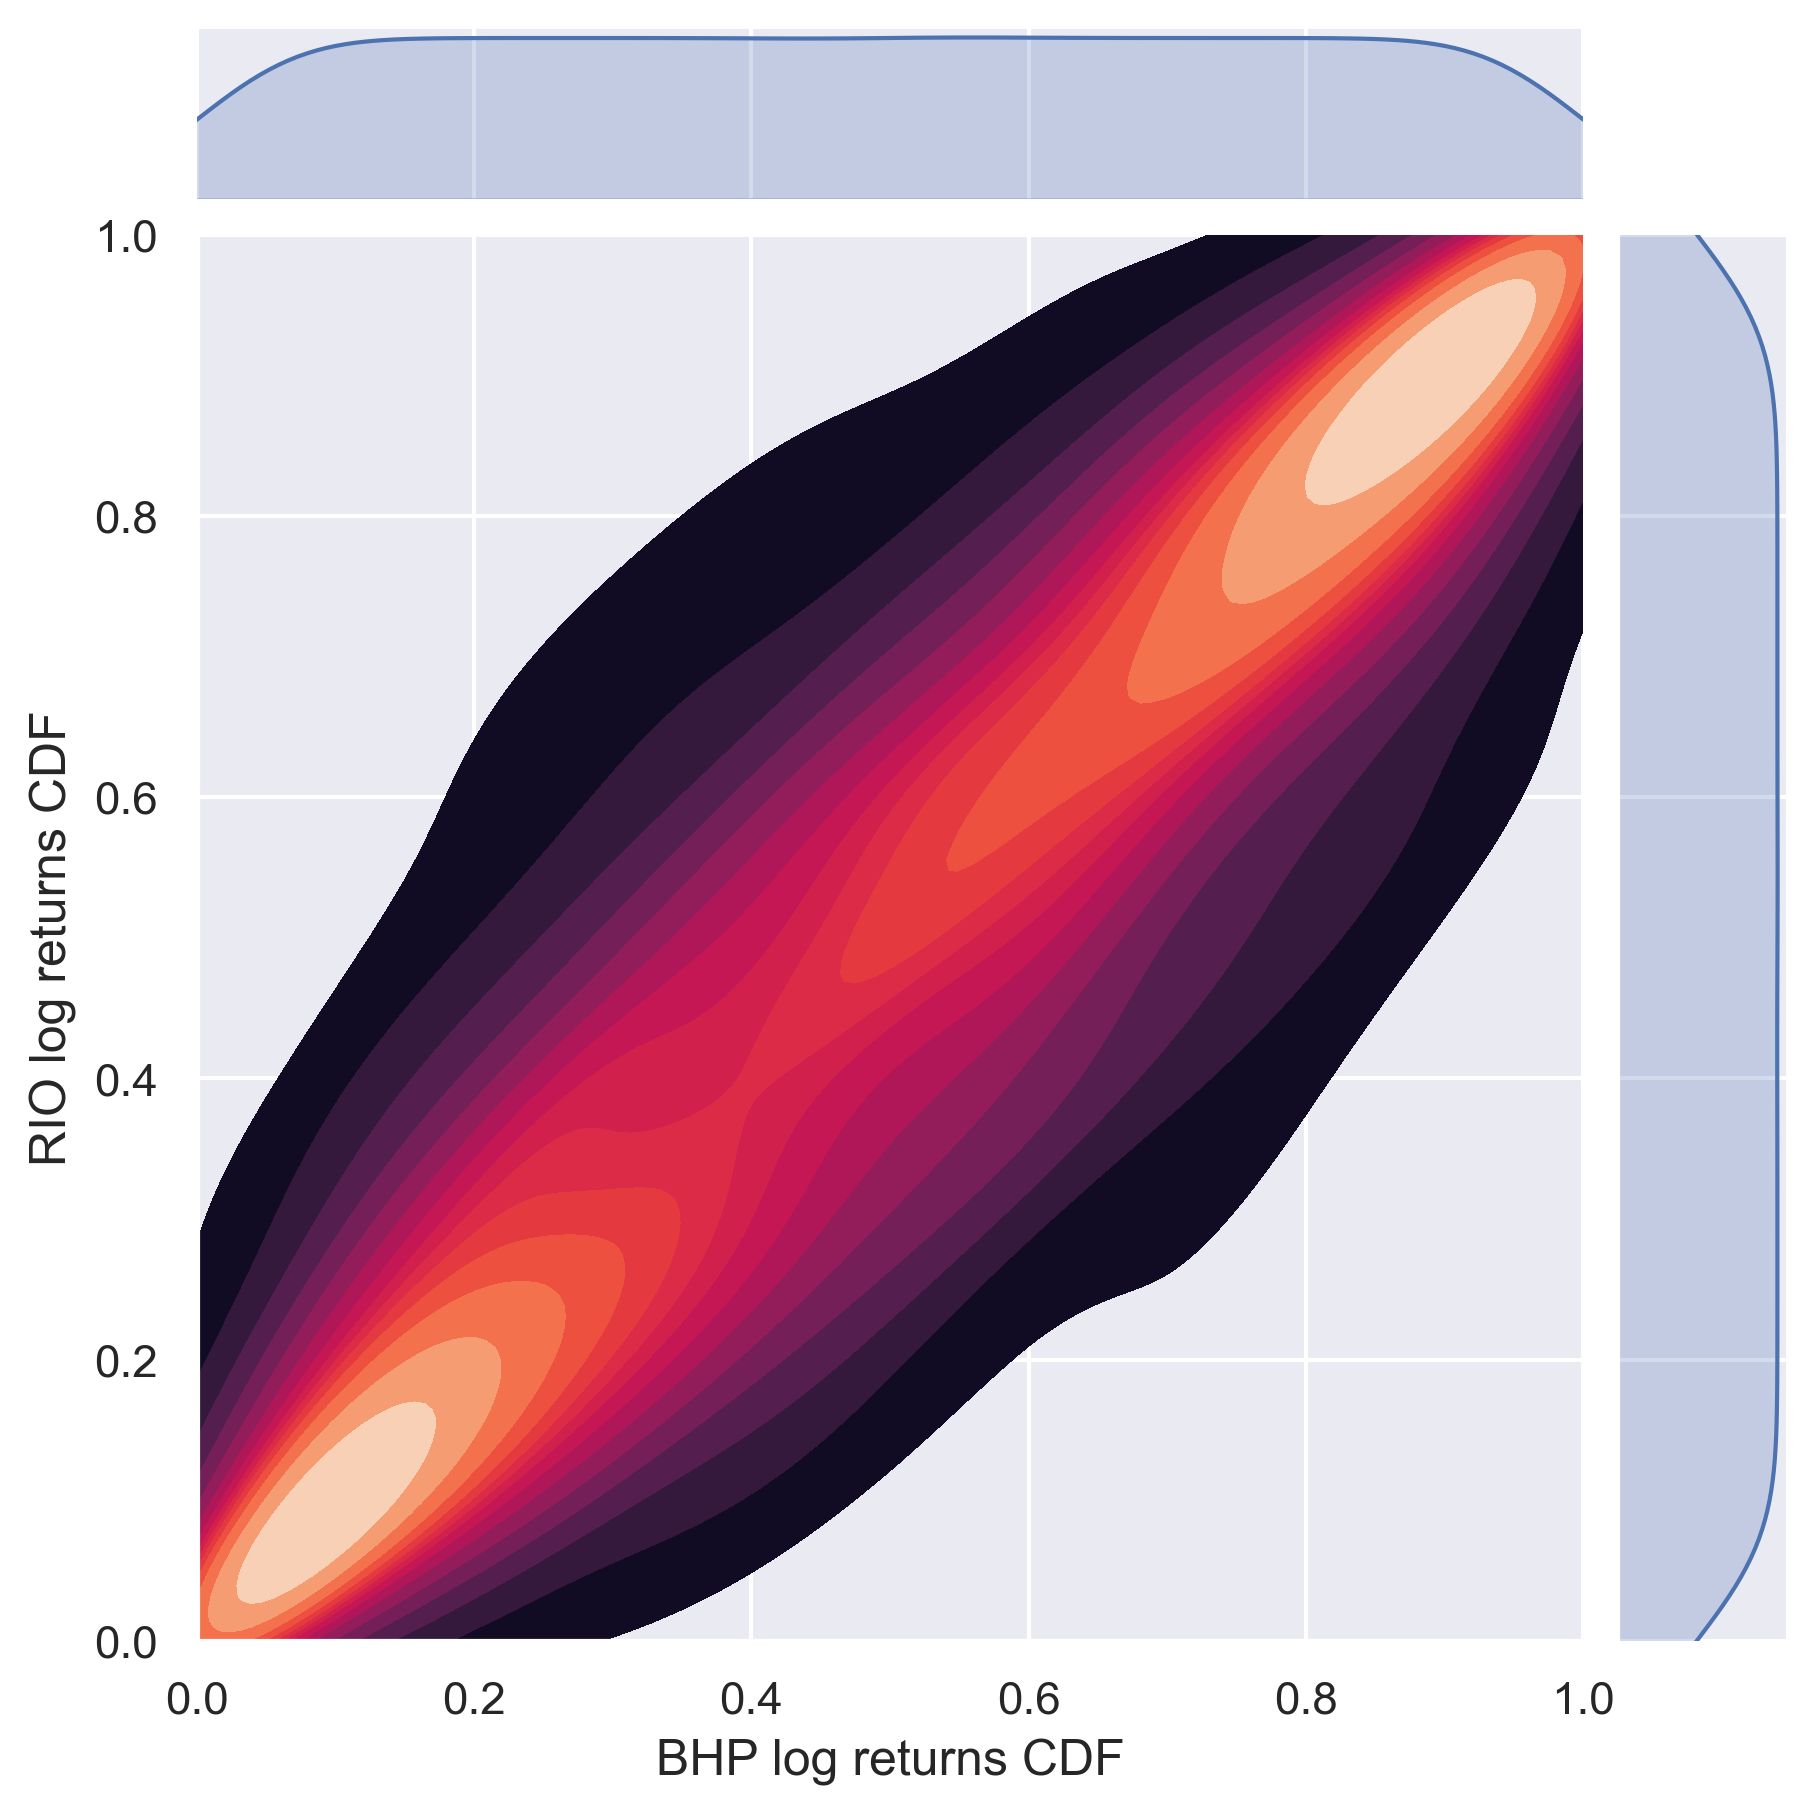

In [154]:
h = sns.jointplot(x=u.T[0], y=u.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels("BHP log returns CDF", "RIO log returns CDF")

In [152]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

def get_variables(S1, S2): # drops the first term
    x = (np.log(S1) - np.log(S1.shift(1)))[1:]
    y = (np.log(S2) - np.log(S2.shift(1)))[1:]
    # cumulative distribution function (marginal distributions)
    ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
    # u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]

    # S1 is the first column of u, S2 is the second
    u = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T
    return x, y, u
x, y, u = get_variables(S1, S2)

u[:5]

array([[0.69498222, 0.92493086],
       [0.32872382, 0.24417226],
       [0.4227578 , 0.14105097],
       [0.27736073, 0.2121691 ],
       [0.55788226, 0.57210589]])

In [160]:
def get_model(u):
    model = pv.Bicop(data=u)
    return model
get_model(u).parameters[0]

array([3.19703712e+02, 2.06136049e+02, 8.90629045e+01, 2.48950327e+01,
       6.11909481e+00, 2.04500200e+00, 9.02889628e-01, 5.01681969e-01,
       1.52175287e-01, 7.77011615e-02, 5.86148544e-02, 2.36587783e-02,
       2.05034407e-04, 9.28997045e-07, 6.74514649e-13, 6.67891747e-09,
       1.74658988e-16, 9.48936105e-11, 1.46203699e-14, 3.78211561e-39,
       4.73279762e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

<Axes: >

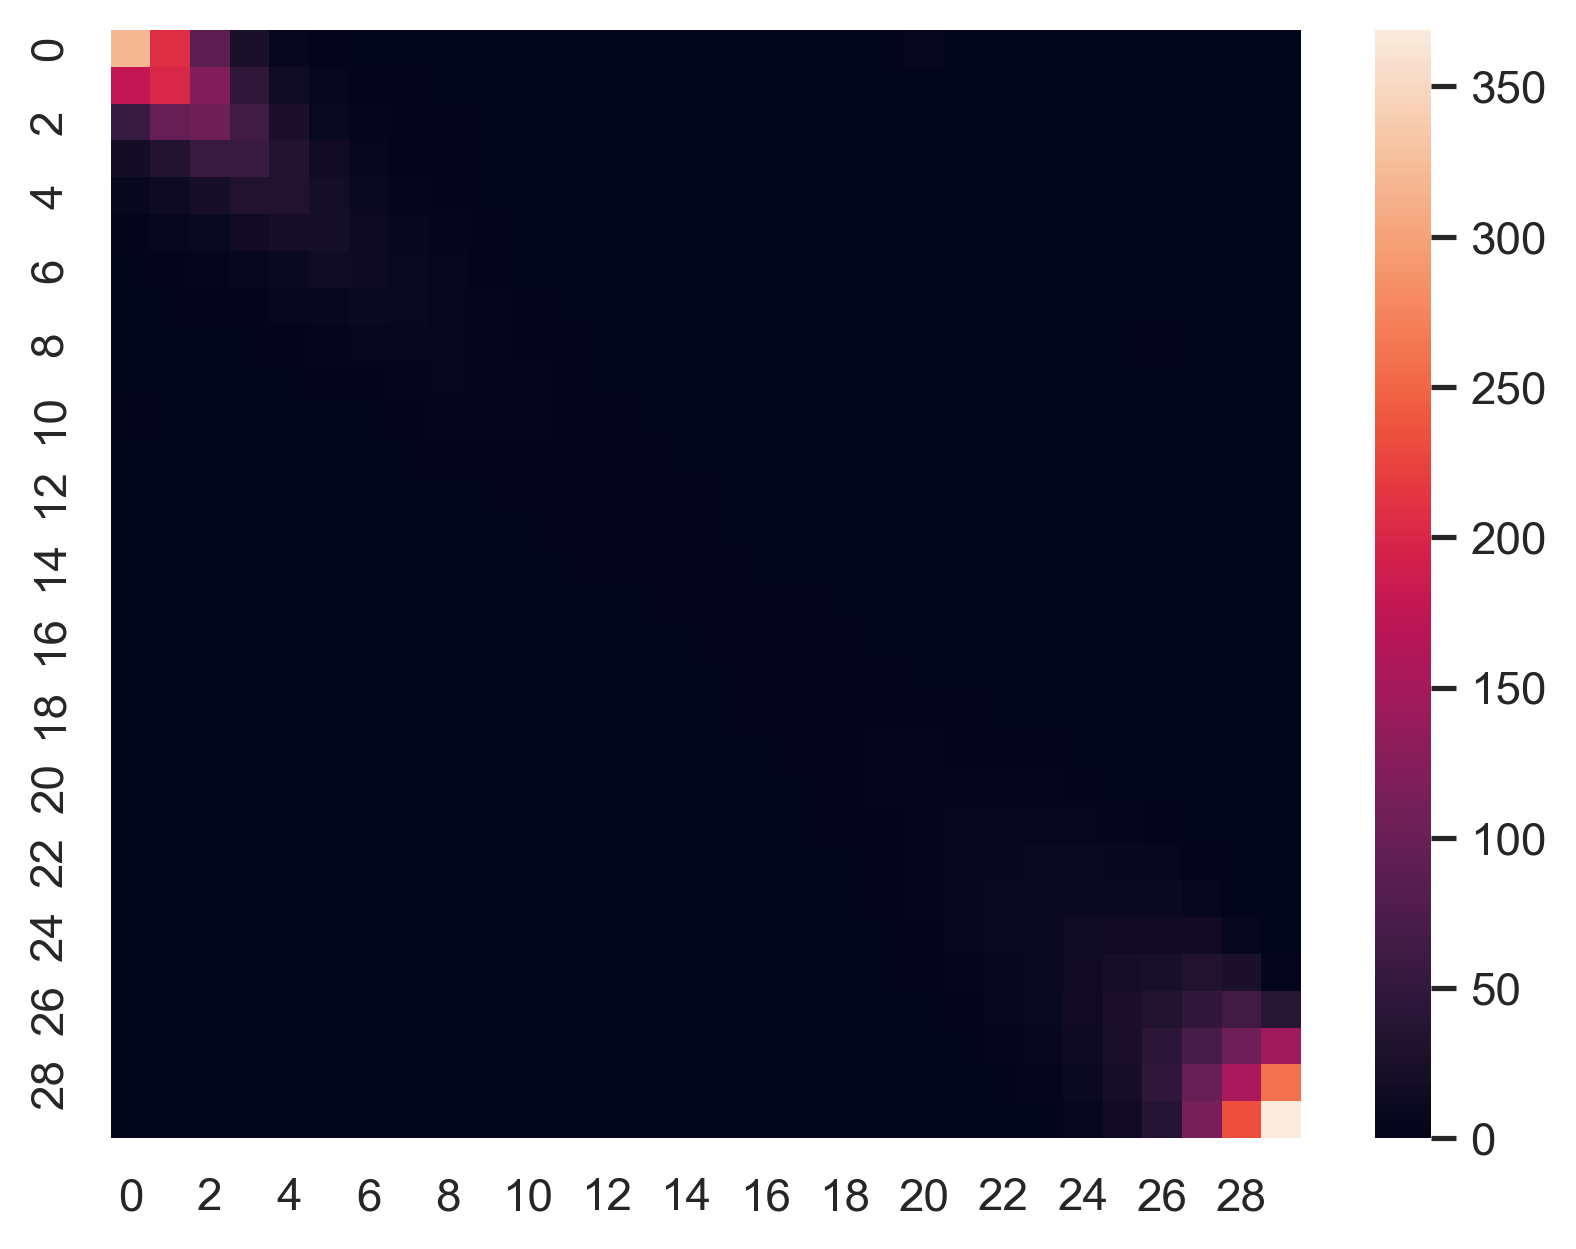

In [161]:
sns.heatmap(get_model(u).parameters)

# Calculate the mispricing index

In [165]:
def mispricing_index(model, u):
    MI_v_u = model.hfunc1(u)
    MI_u_v = model.hfunc2(u)
    return MI_u_v, MI_v_u

S1 = data['BHP.AX']
S2 = data['RIO.AX']

# remember that these variables are one less than started
x, y, u = get_variables(S1, S2)

cop = get_model(u)
mispricing_index(cop, u)

(array([0.09511229, 0.6118642 , 0.90812009, ..., 0.15419767, 0.1009431 ,
        0.57264448]),
 array([0.97235905, 0.27688262, 0.04307904, ..., 0.94015038, 0.79763324,
        0.36389044]))

## trading strategy
copying paper: Pairs Trading with Copulas May 3, 2014

In [171]:
# type 1, no lookback yet

def simulate_trades_nolook(S1, S2):
    # convert all to timeseries later
    x, y, u = get_variables(S1, S2)
    cop = get_model(u)
    MI_x_y, MI_y_x = mispricing_index(cop, u)
    # Setup stating parametesrs
    # Starting signals
    flagX = 0 # trading indicators
    flagY = 0 

    weightY = 1
    n_X = 0
    n_Y = 0
    returns = 0
    # numbers taken from paper
    D = 0.6 # trigger point from [-0.5, 0.5]
    S = 2 # Stop loss position

    # as the log returns start with a nan day
    S1 = S1[1:]  
    S2 = S2[1:]

    # Series
    rs = 0*S1

    for i in range(len(S1)): # each 'day'
        # accumulations of the daily (MI_x_y-0.5) and (MI_y_x-0.5)
        flagX += (MI_x_y[i]-0.5)
        flagY += (MI_y_x[i]-0.5)

        #todo may want to make it so the if statement is "reaches", not < or >
        #todo implement stop loss


        #* When FlagX reaches D, we short-sell stock X and buy stock Y in equal amounts.
        #* When FlagY reaches -D, we short-sell stock X and buy stock Y in equal amounts.
        
        if flagX > D and flagY < -D:
            # buy stock Y
            n_Y +=  weightY
            returns -= weightY*S2[i]

            # should you use a proportion?
            # Short sell stock X
            n_X -= weightY
            returns += weightY*S1[i]

        #? When FlagX reaches -D, we short-sell stock Y and buy stock X in equal amounts.
        #? When FlagY reaches D, we short-sell stock Y and buy stock X in equal amounts.
        elif flagX < -D and flagY > D:
            # short sell stock Y
            n_Y -=  weightY
            returns += weightY*S2[i]

            # should you use a proportion?
            # buy X
            n_X += weightY
            returns -= weightY*S1[i]
        rs[i] = returns + n_X*S1[i] + n_Y*S2[i]
    return rs

S1 = data['BHP.AX']
S2 = data['RIO.AX']

rs = simulate_trades_nolook(S1, S2)

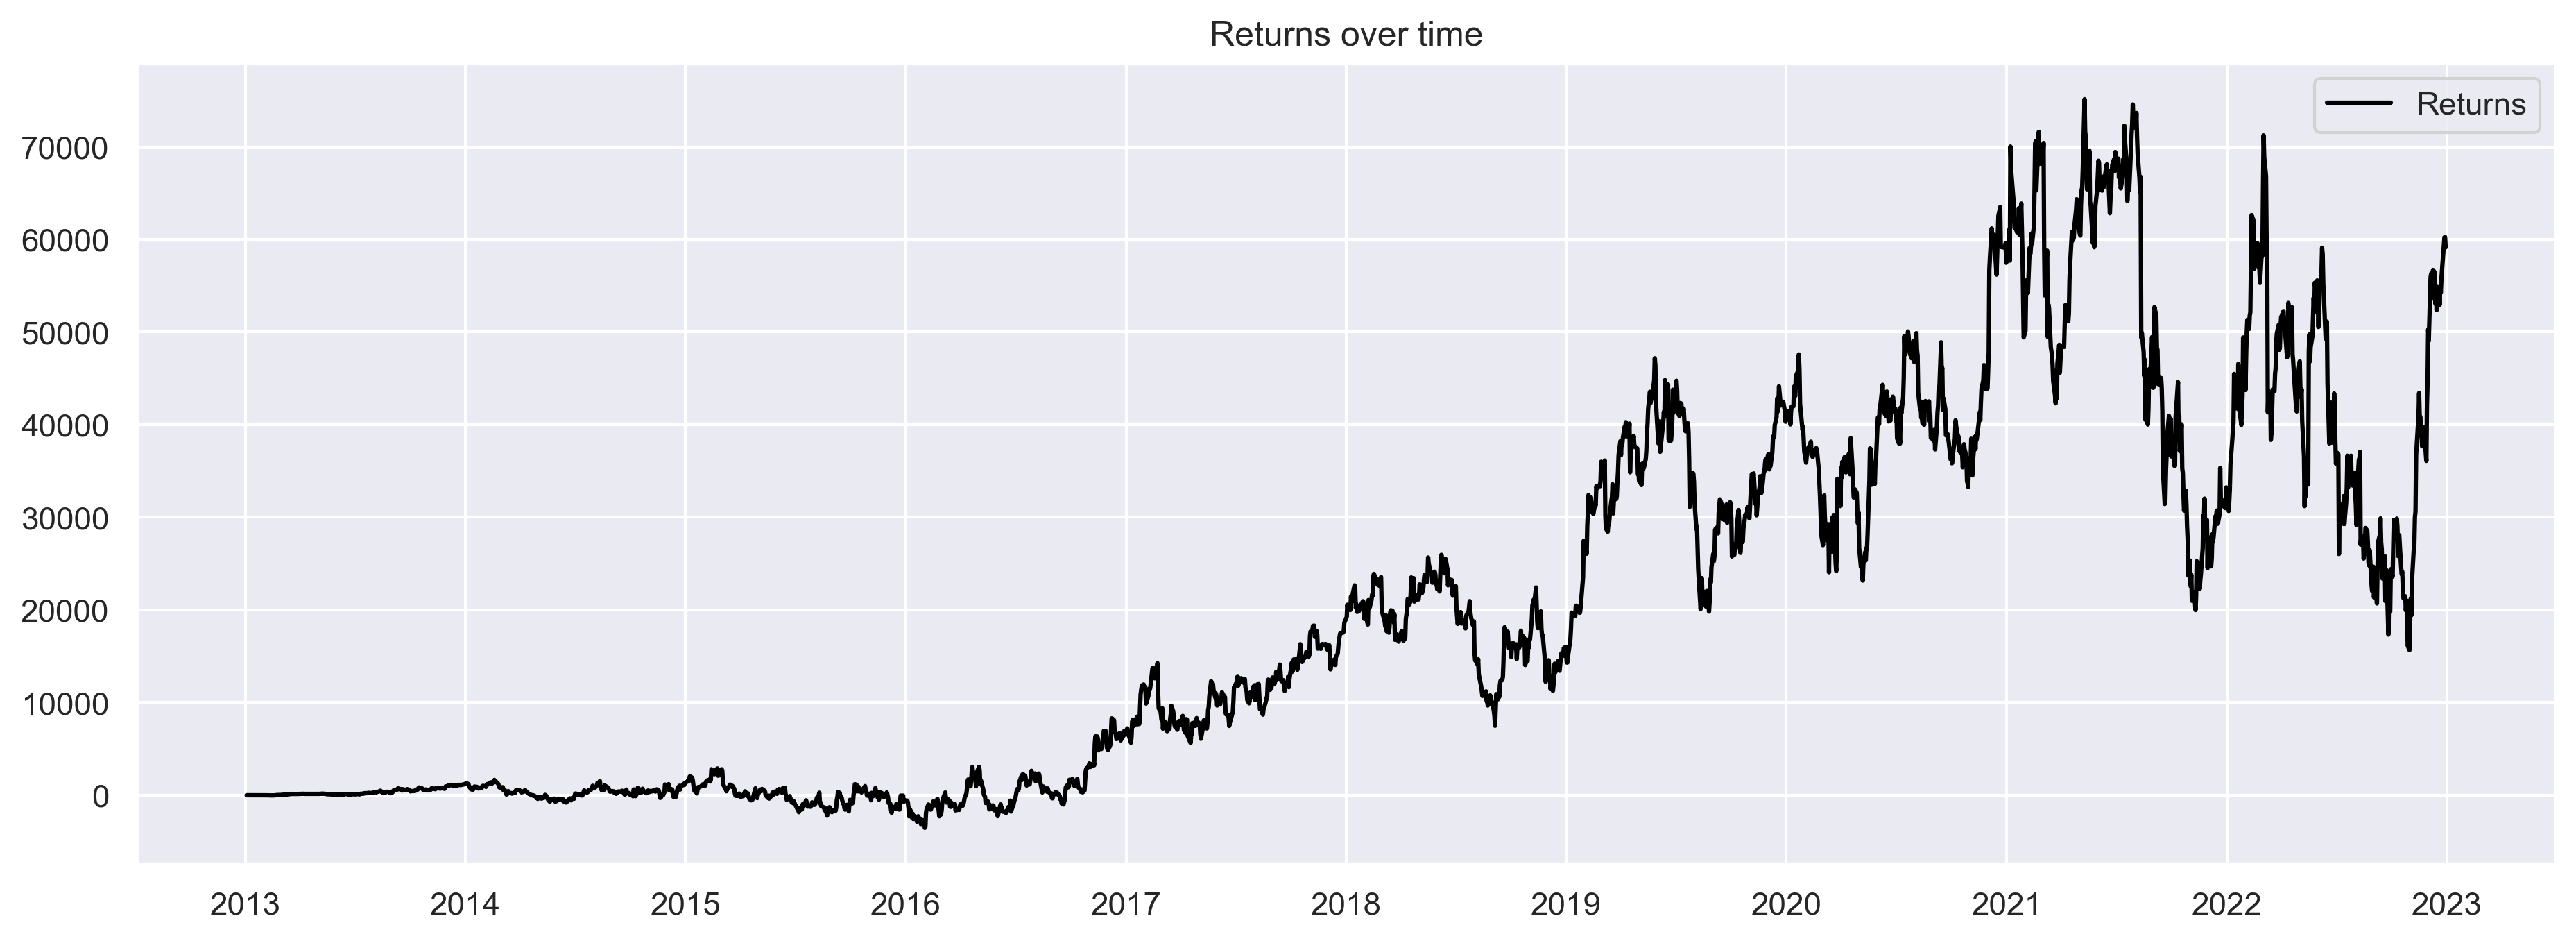

In [172]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(rs, color='black')
plt.legend(['Returns'])
plt.show()

# Lookback period variation

In [1]:
# type 1, no lookback yet

def simulate_trades(S1, S2, lookback=150):
    # Setup stating parametesrs
    # Starting signals
    flagX = 0*S1 # trading indicators
    flagY = 0*S1 

    weightY = 1
    n_X = 0
    n_Y = 0
    n_trades = 0
    returns = 0
    # numbers taken from paper
    D = 0.49 # trigger point from [-0.5, 0.5]
    S = 2 # Stop loss position

    # Series
    rs = 0*S1
    MI_x_ys = 0*S1
    MI_y_xs = 0*S1
    copList = []

    for i in range(lookback+1, len(S1), 1):
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]

        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI_x_y, MI_y_x = mispricing_index(cop, u)
        MI_x_ys[i], MI_y_xs[i] = MI_x_y[-1], MI_y_x[-1]
        ## Update copula

        # accumulations of the daily (MI_x_y-0.5) and (MI_y_x-0.5)
        flagX[i] = flagX[i-1] + (MI_x_ys[i]-0.5)
        flagY[i] = flagX[i-1] + (MI_y_xs[i]-0.5)

        #todo may want to make it so the if statement is "reaches", not < or >
        #todo implement stop loss


        #* When FlagX reaches D, we short-sell stock X and buy stock Y in equal amounts.
        #* When FlagY reaches -D, we short-sell stock X and buy stock Y in equal amounts.
        
        if flagX[i] > D or flagY[i] < -D:
            # buy stock Y
            n_Y +=  weightY
            returns -= weightY*S2[i]

            # should you use a proportion?
            # Short sell stock X
            n_X -= weightY
            returns += weightY*S1[i]

            n_trades += 1

        #? When FlagX reaches -D, we short-sell stock Y and buy stock X in equal amounts.
        #? When FlagY reaches D, we short-sell stock Y and buy stock X in equal amounts.
        elif flagX[i] < -D or flagY[i] > D:
            # short sell stock Y
            n_Y -=  weightY
            returns += weightY*S2[i]

            # should you use a proportion?
            # buy X
            n_X += weightY
            returns -= weightY*S1[i]

            n_trades += 1
        
        #! If flagX or flagY pass the stop loss, exit all positions
        if abs(flagX[i]) > S or abs(flagY[i]) > S:
            returns += n_X*S1[i] + n_Y*S2[i] 
            n_X = 0
            n_Y = 0

            flagX[i] = 0
            flagY[i] = 0
            print("reset",i)

        rs[i] = returns + n_X*S1[i] + n_Y*S2[i]
    
    return rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs

S1 = data['BHP.AX']
S2 = data['RIO.AX']

rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs  = simulate_trades(S1, S2)
n_trades

NameError: name 'data' is not defined

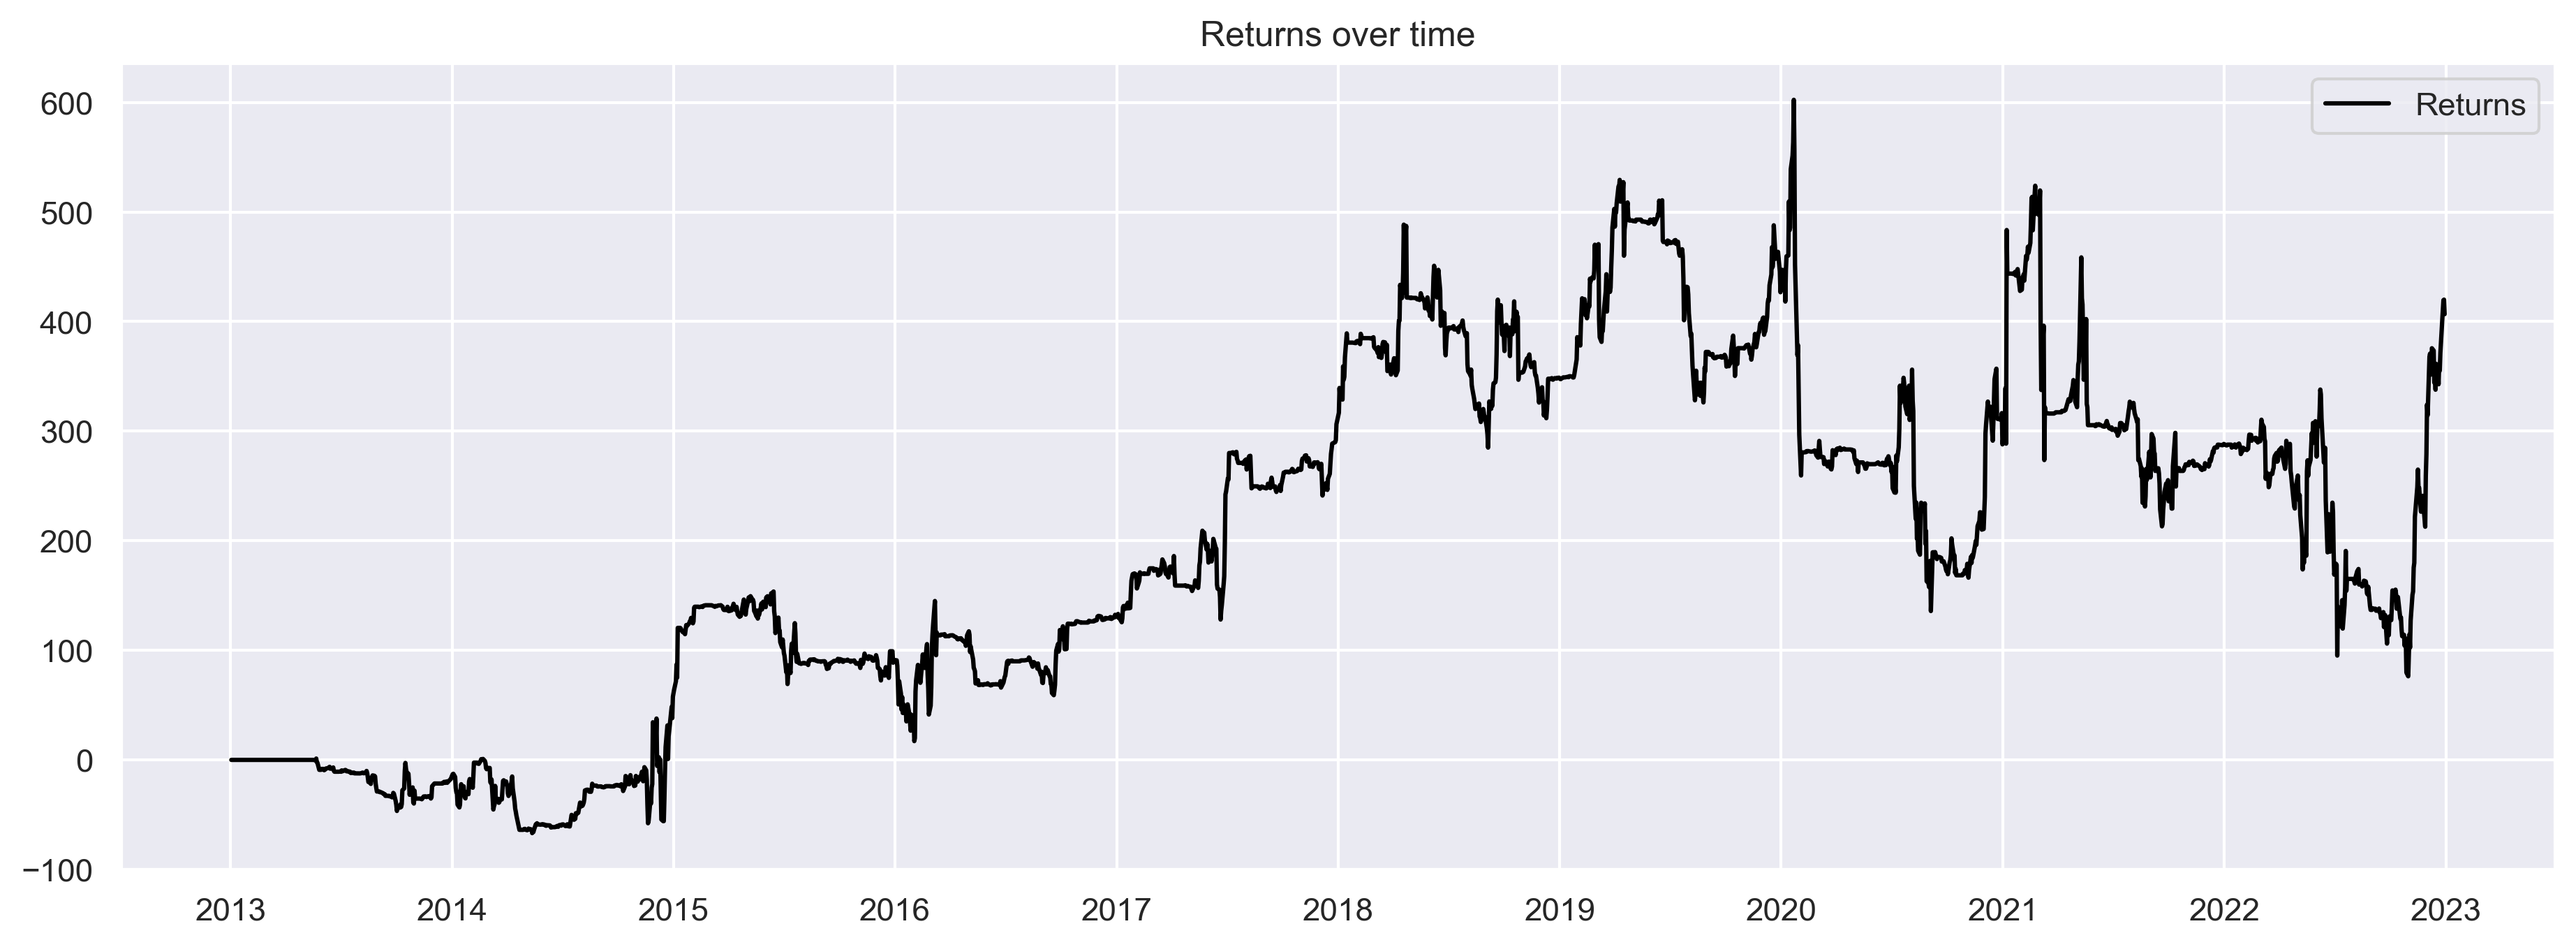

In [271]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(rs, color='black')
plt.legend(['Returns'])
plt.show()

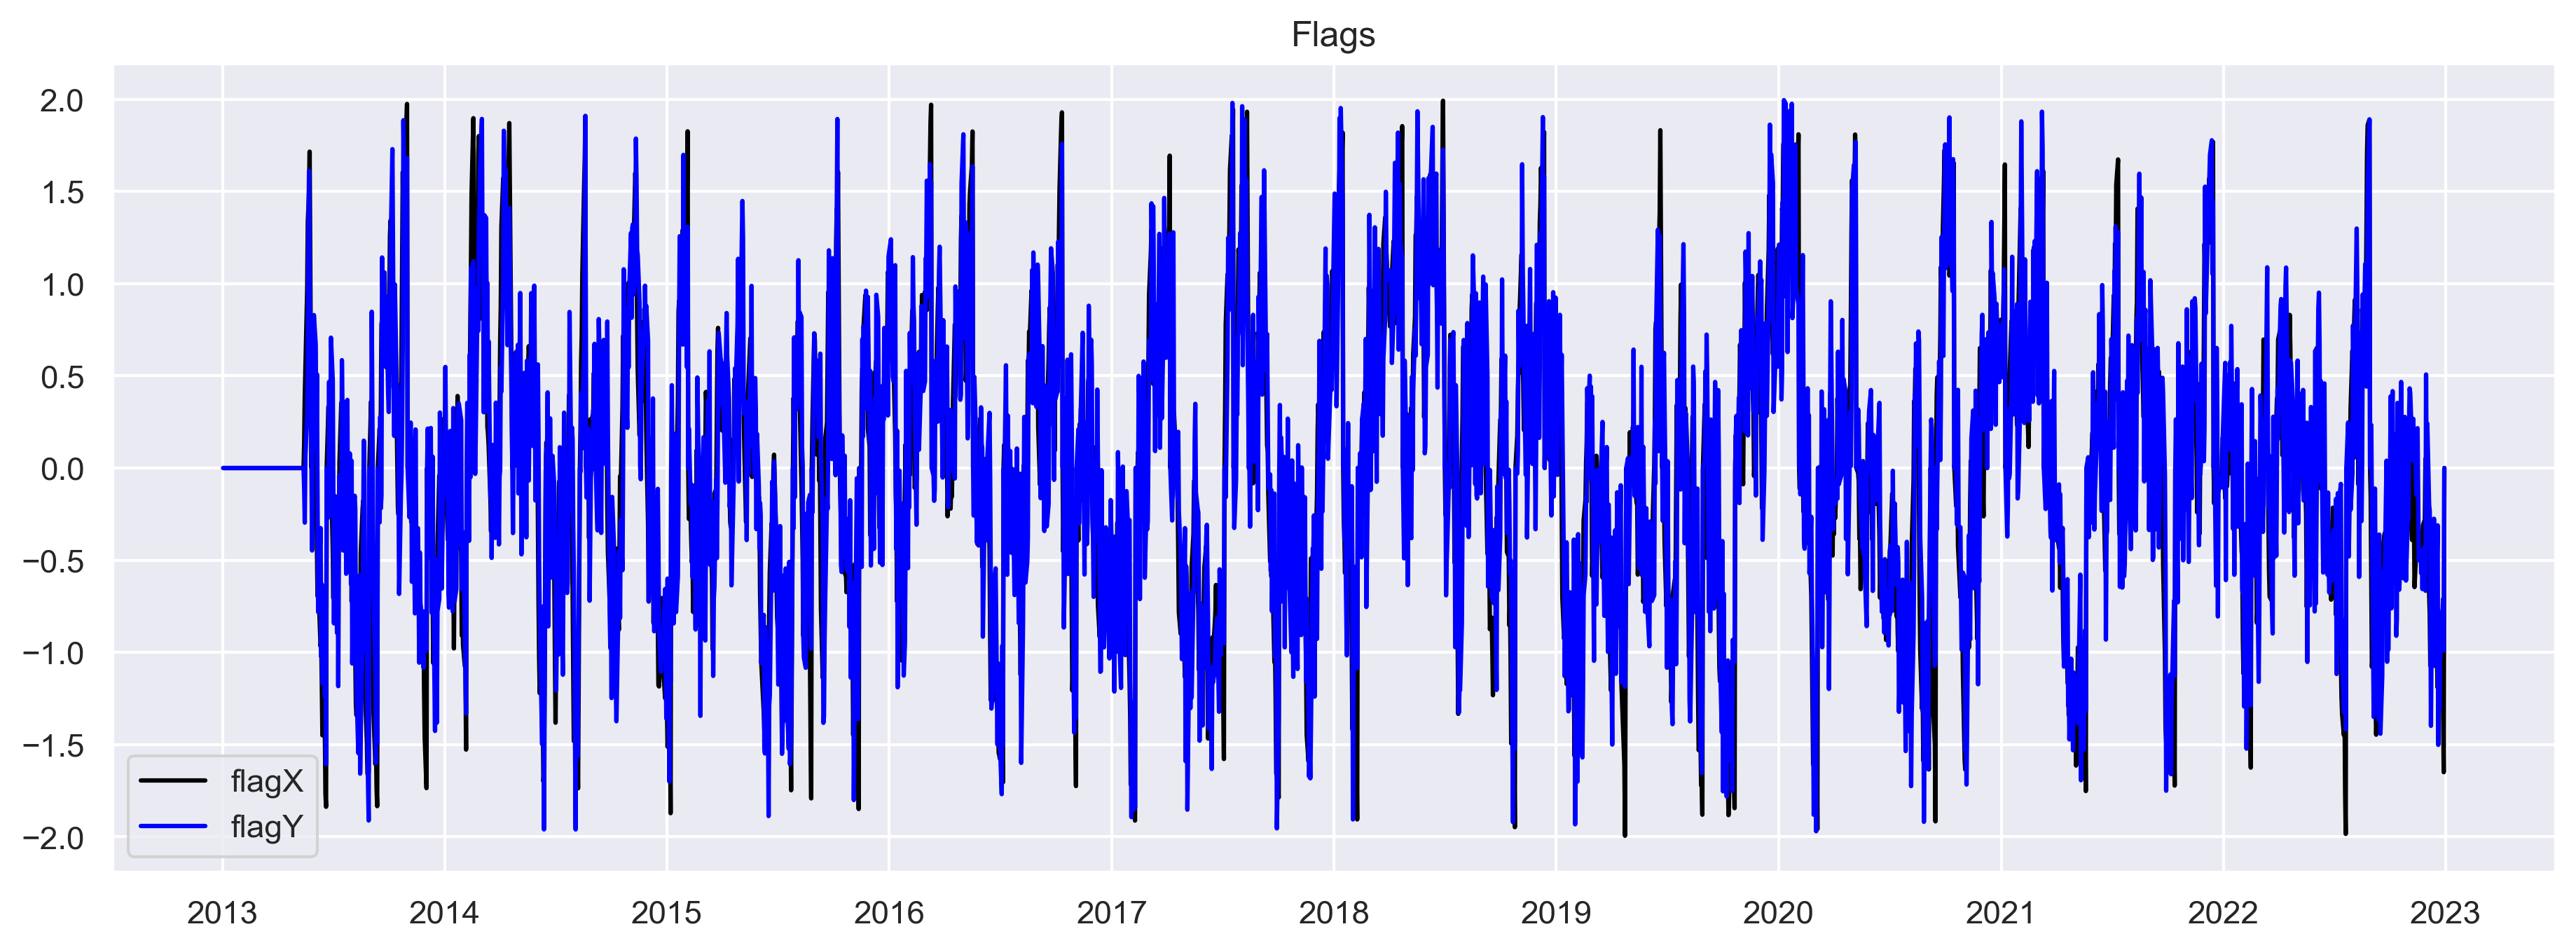

In [272]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(flagX, color='black')
plt.plot(flagY, color='blue')

plt.legend(['flagX', 'flagY'])
plt.show()

# Pairs trading: A copula approach
Received (in revised form): 22nd January 2013

In [301]:
def simulate_trades_revised(S1, S2, lookback=50, weight_S2=1):

    ### Trading variables
    upper_CB = 0.95 # upper confidence bound
    lower_CB = 0.05 # lower confidence bound
    EB = 0.5 # Exit bound

    ### Form timeseries
    returns = 0*S1
    totalReturns = 0*S1
    n_S1 = 0*S1
    n_S2 = 0*S1
    MI_u_v = 0*S1 # Mispricing Index of S1 given S2
    MI_v_u = 0*S1 # Mispricing Index of S2 given S1
    copList = []

    ### Testing
    n_trades =0

    for i in range(lookback+1, len(S1), 1): # add 1 to avoid the nan at start

        returns[i] = returns[i-1]
        totalReturns[i] = totalReturns[i-1]

        n_S1[i] = n_S1[i-1]
        n_S2[i] = n_S2[i-1]

        ## Setup the copula
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]
        # log returns
        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI1, MI2 = mispricing_index(cop, u)
        MI_u_v[i], MI_v_u[i] = MI1[-1], MI2[-1]

        # coef = stats.linregress(x, y).slope
        coef = 1
        ## Make trades 
        price_S1, price_S2 = rolling_S1[-1], rolling_S2[-1]
        
        # if S1 is undervalued and S2 is overvalued, go long
        # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
        if MI_u_v[i] < lower_CB and MI_v_u[i] > upper_CB:
            # sell S2 by weight
            n_S2[i] -= weight_S2
            returns[i] += weight_S2*price_S2
            # buy S1 by weight * coefficient * long/short price ratio
            n_S1[i] += (weight_S2 * coef * (price_S1/price_S2))
            returns[i] -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # buy[i] = price_S1
            # sell[i] = price_S2

            n_trades += 1

        # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
        elif MI_u_v[i] > lower_CB and MI_v_u[i] < upper_CB:
            # buy S2 by weight
            n_S2[i] += weight_S2
            returns[i] -= weight_S2*price_S2
            # sell S1 by weight * coefficient * long/short price ratio
            n_S1[i] -= (weight_S2 * coef * (price_S1/price_S2))
            returns[i] += (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # sell[i] = price_S1
            # buy[i] = price_S2

            n_trades += 1

        # if it crosses the exit threshold, liquidate positions
        elif ((MI_u_v[i] < EB and MI_u_v[i-1] > EB) or (MI_u_v[i] > EB and MI_u_v[i-1] < EB)) \
         and ((MI_v_u[i] < EB and MI_v_u[i-1] > EB) or (MI_v_u[i] > EB and MI_v_u[i-1] < EB)):
            
            returns[i] += n_S1[i]*price_S1 + n_S2[i]*price_S2
            n_S1[i] = 0
            n_S2[i] = 0

            # liquidateS1[i] = price_S1
            # liquidateS2[i] = price_S2

        totalReturns[i] = returns[i] + n_S1[i]*price_S1 + n_S2[i]*price_S2

    return totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades


S1 = data['BHP.AX']
S2 = data['RIO.AX']

totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades = simulate_trades_revised(S1, S2)
n_trades

2111

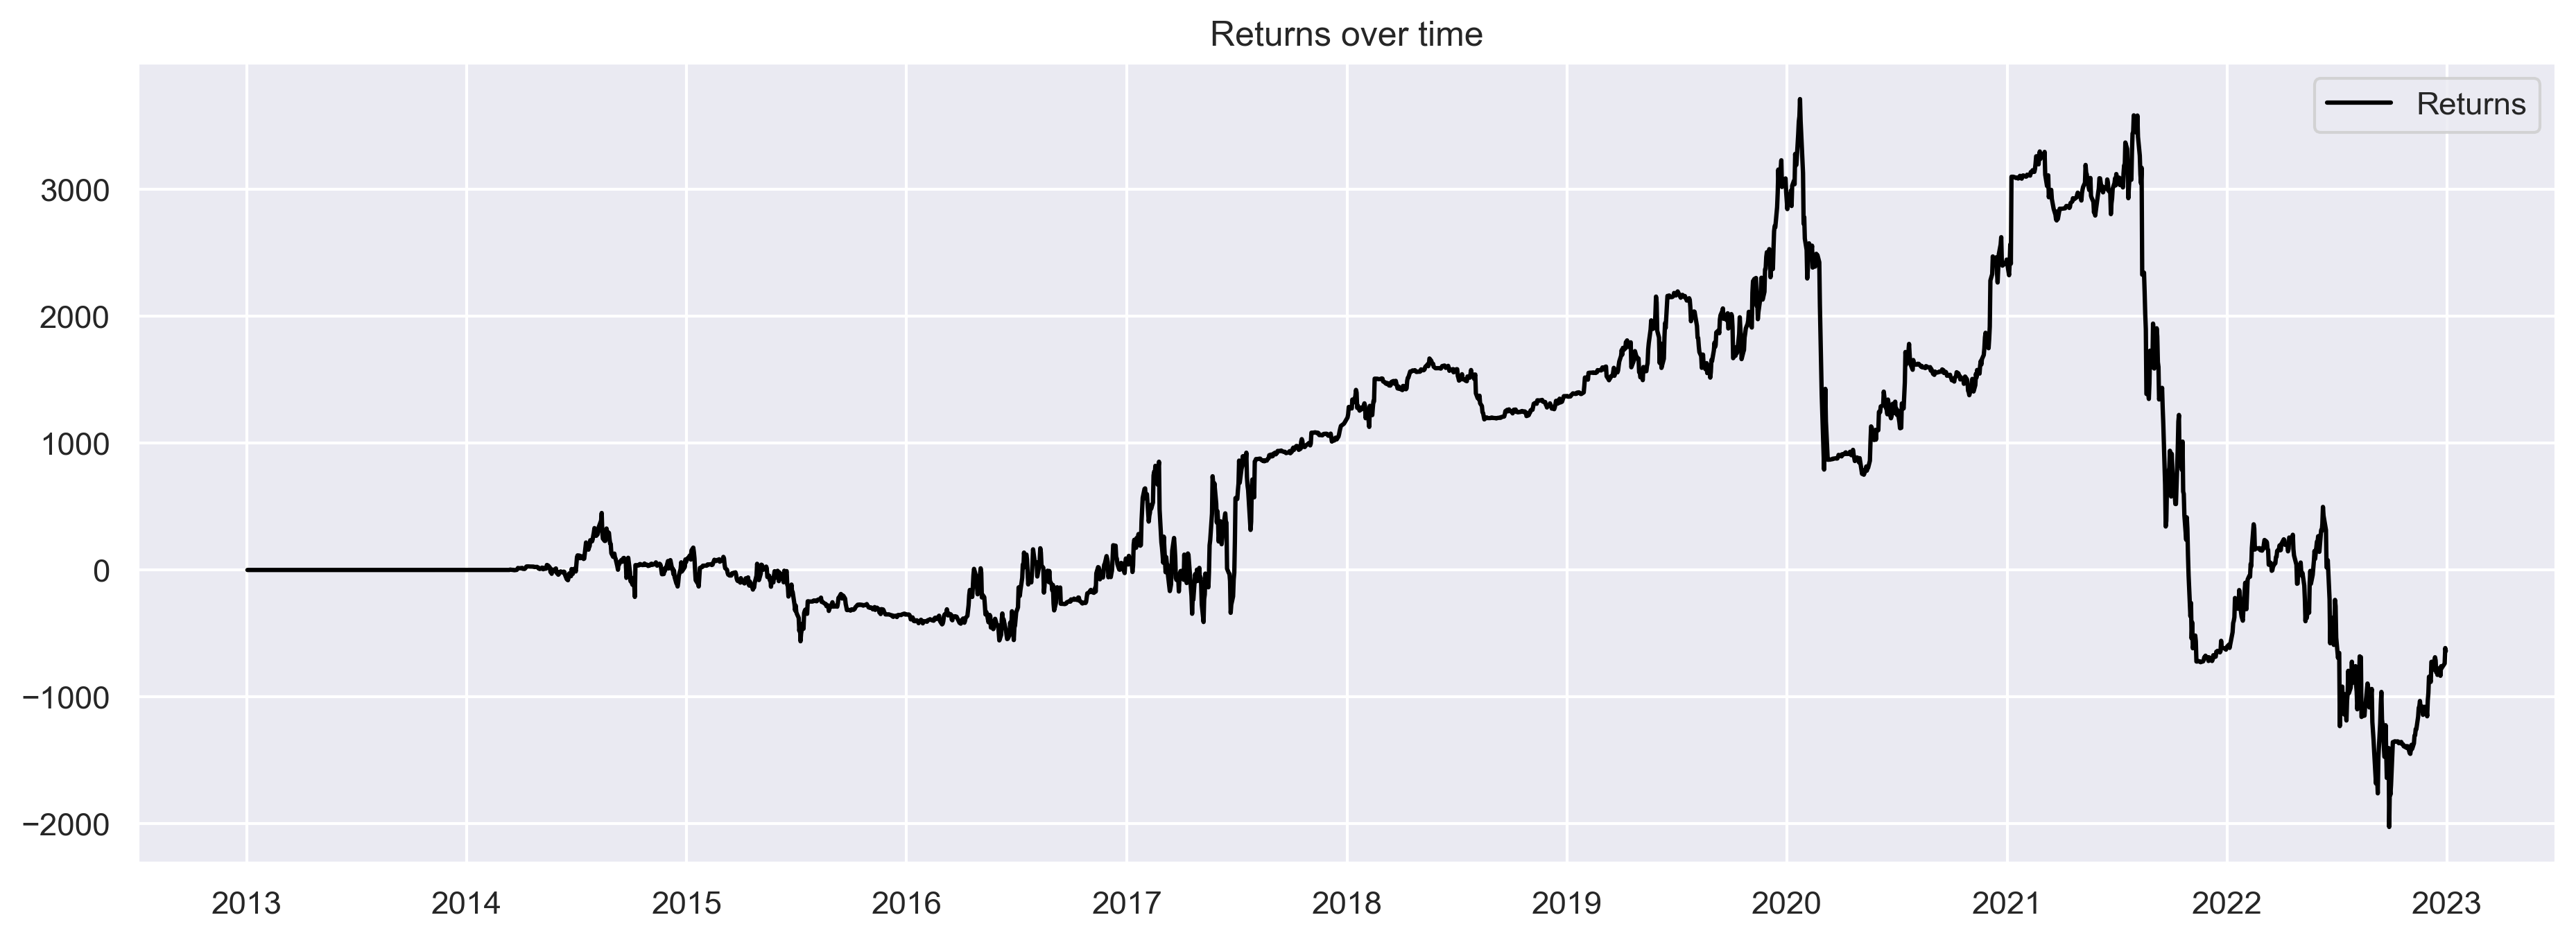

In [302]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(totalReturns, color='black')
plt.legend(['Returns'])
plt.show()

In [299]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

# remember that these variables are one less than started
x, y, u = get_variables(S1, S2)

copu = pv.Bicop(family=pv.BicopFamily.student)
copu.fit(data=u)
mispricing_index(copu, u)

(array([0.10058988, 0.61306898, 0.90132129, ..., 0.15765351, 0.09207419,
        0.56795239]),
 array([0.9743322 , 0.25836745, 0.04163189, ..., 0.94260263, 0.80039575,
        0.35026697]))

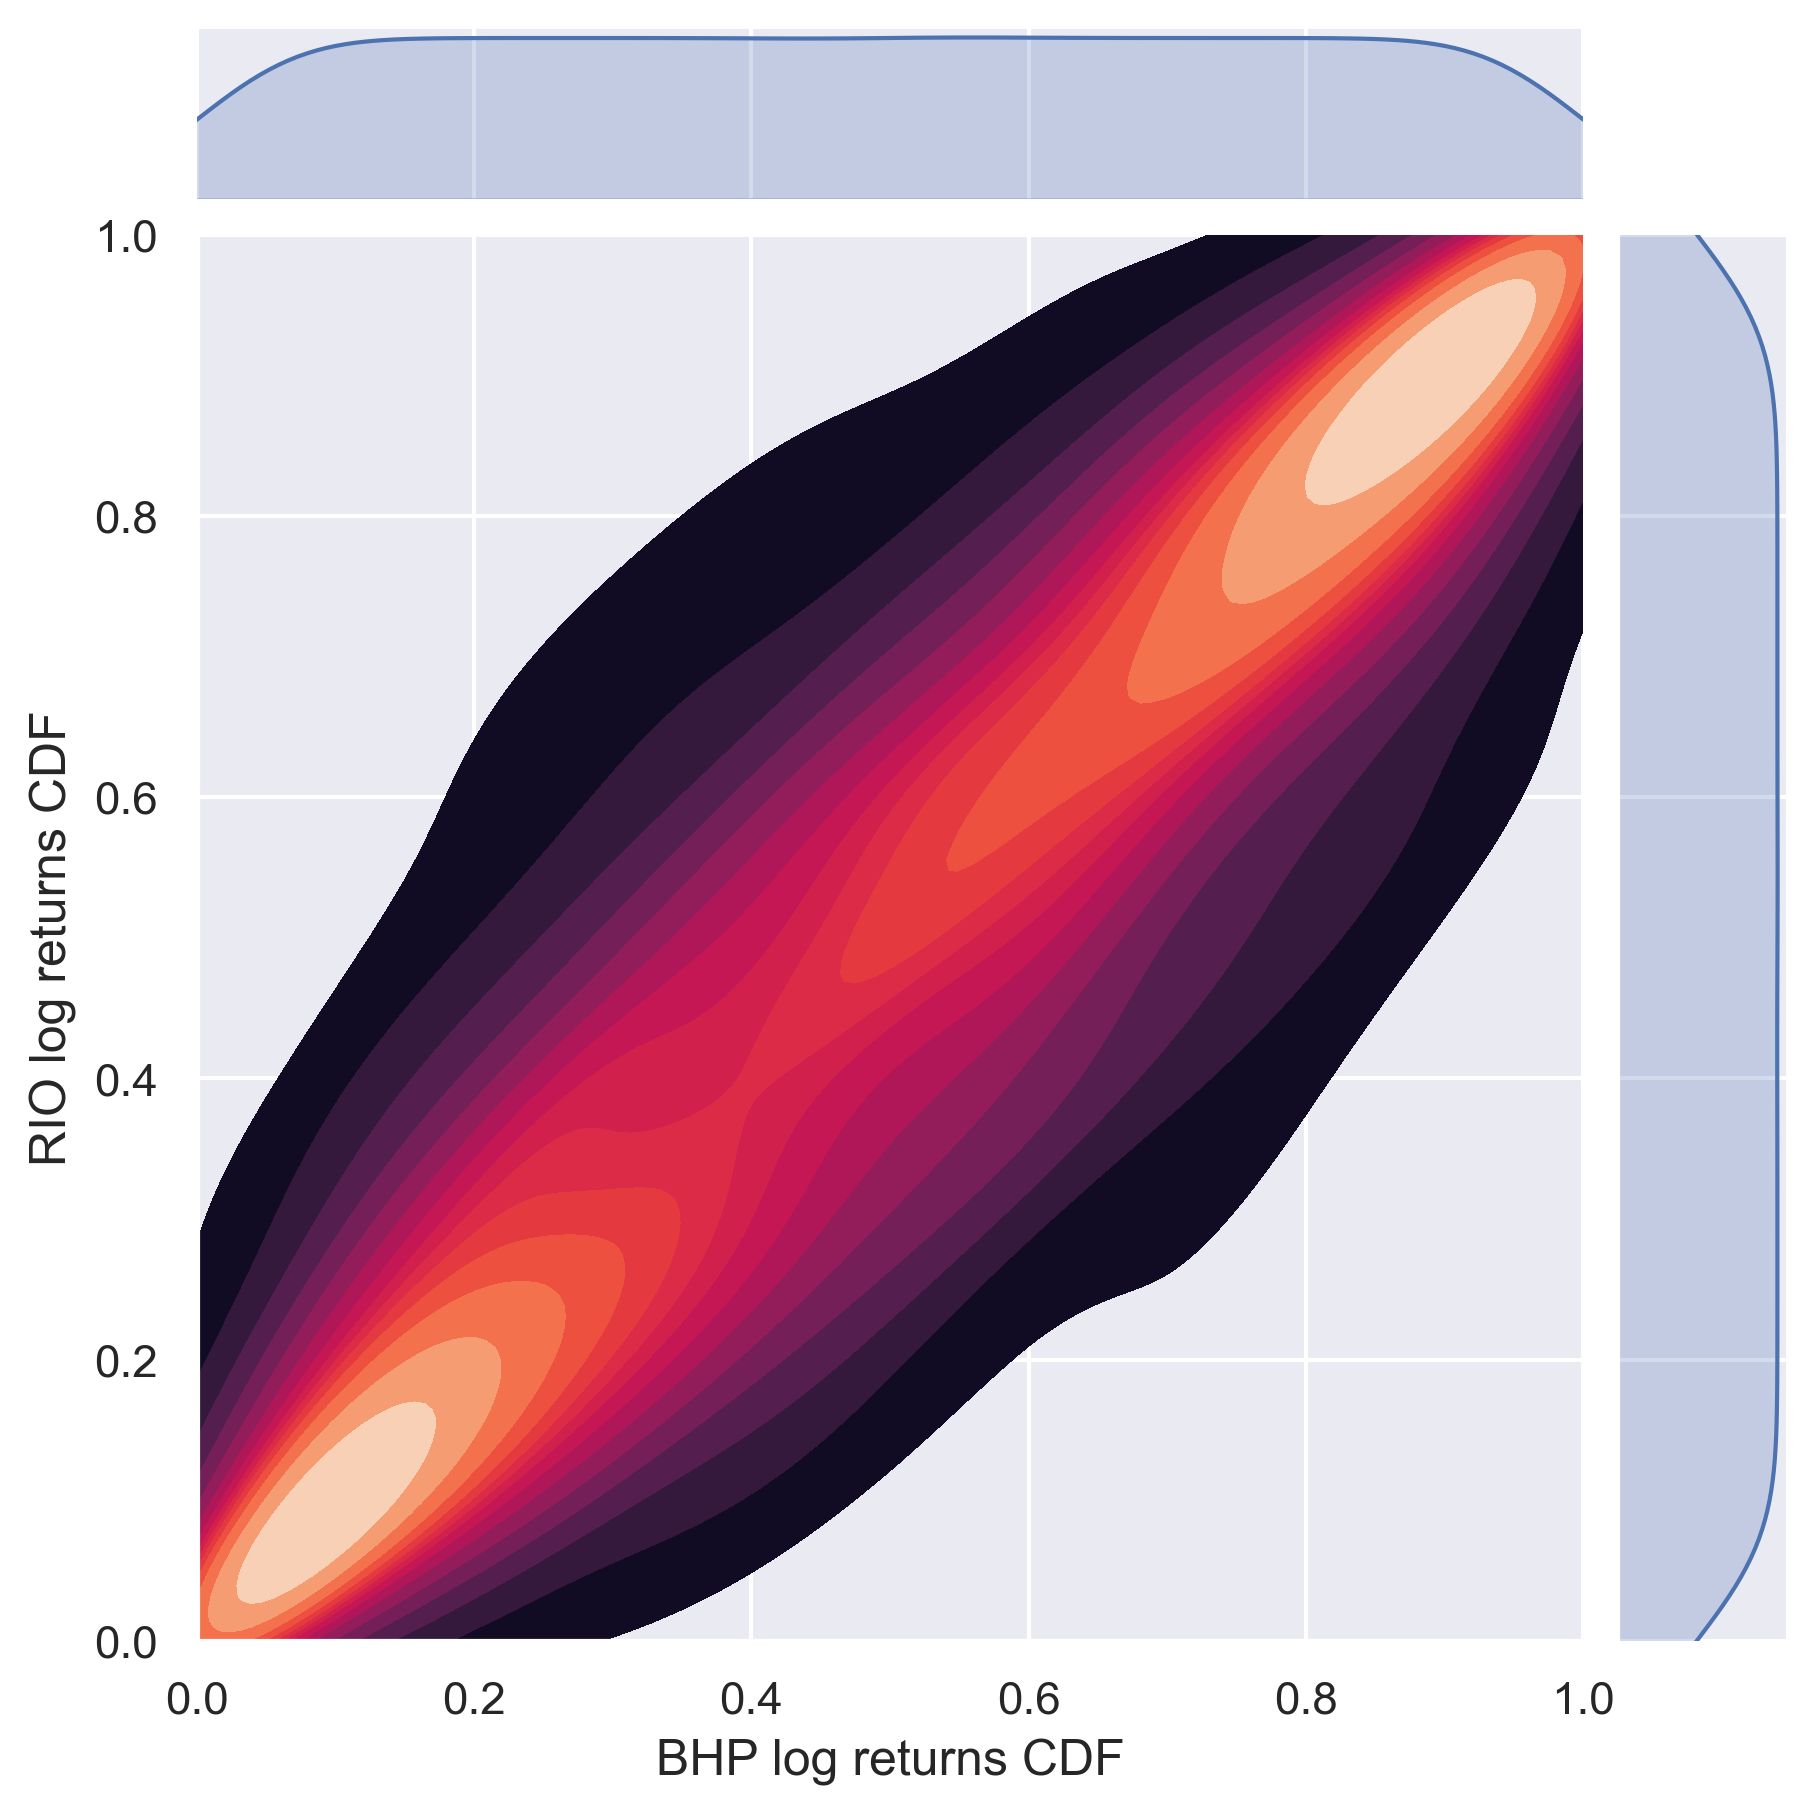

In [294]:
h = sns.jointplot(x=u.T[0], y=u.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels("BHP log returns CDF", "RIO log returns CDF")

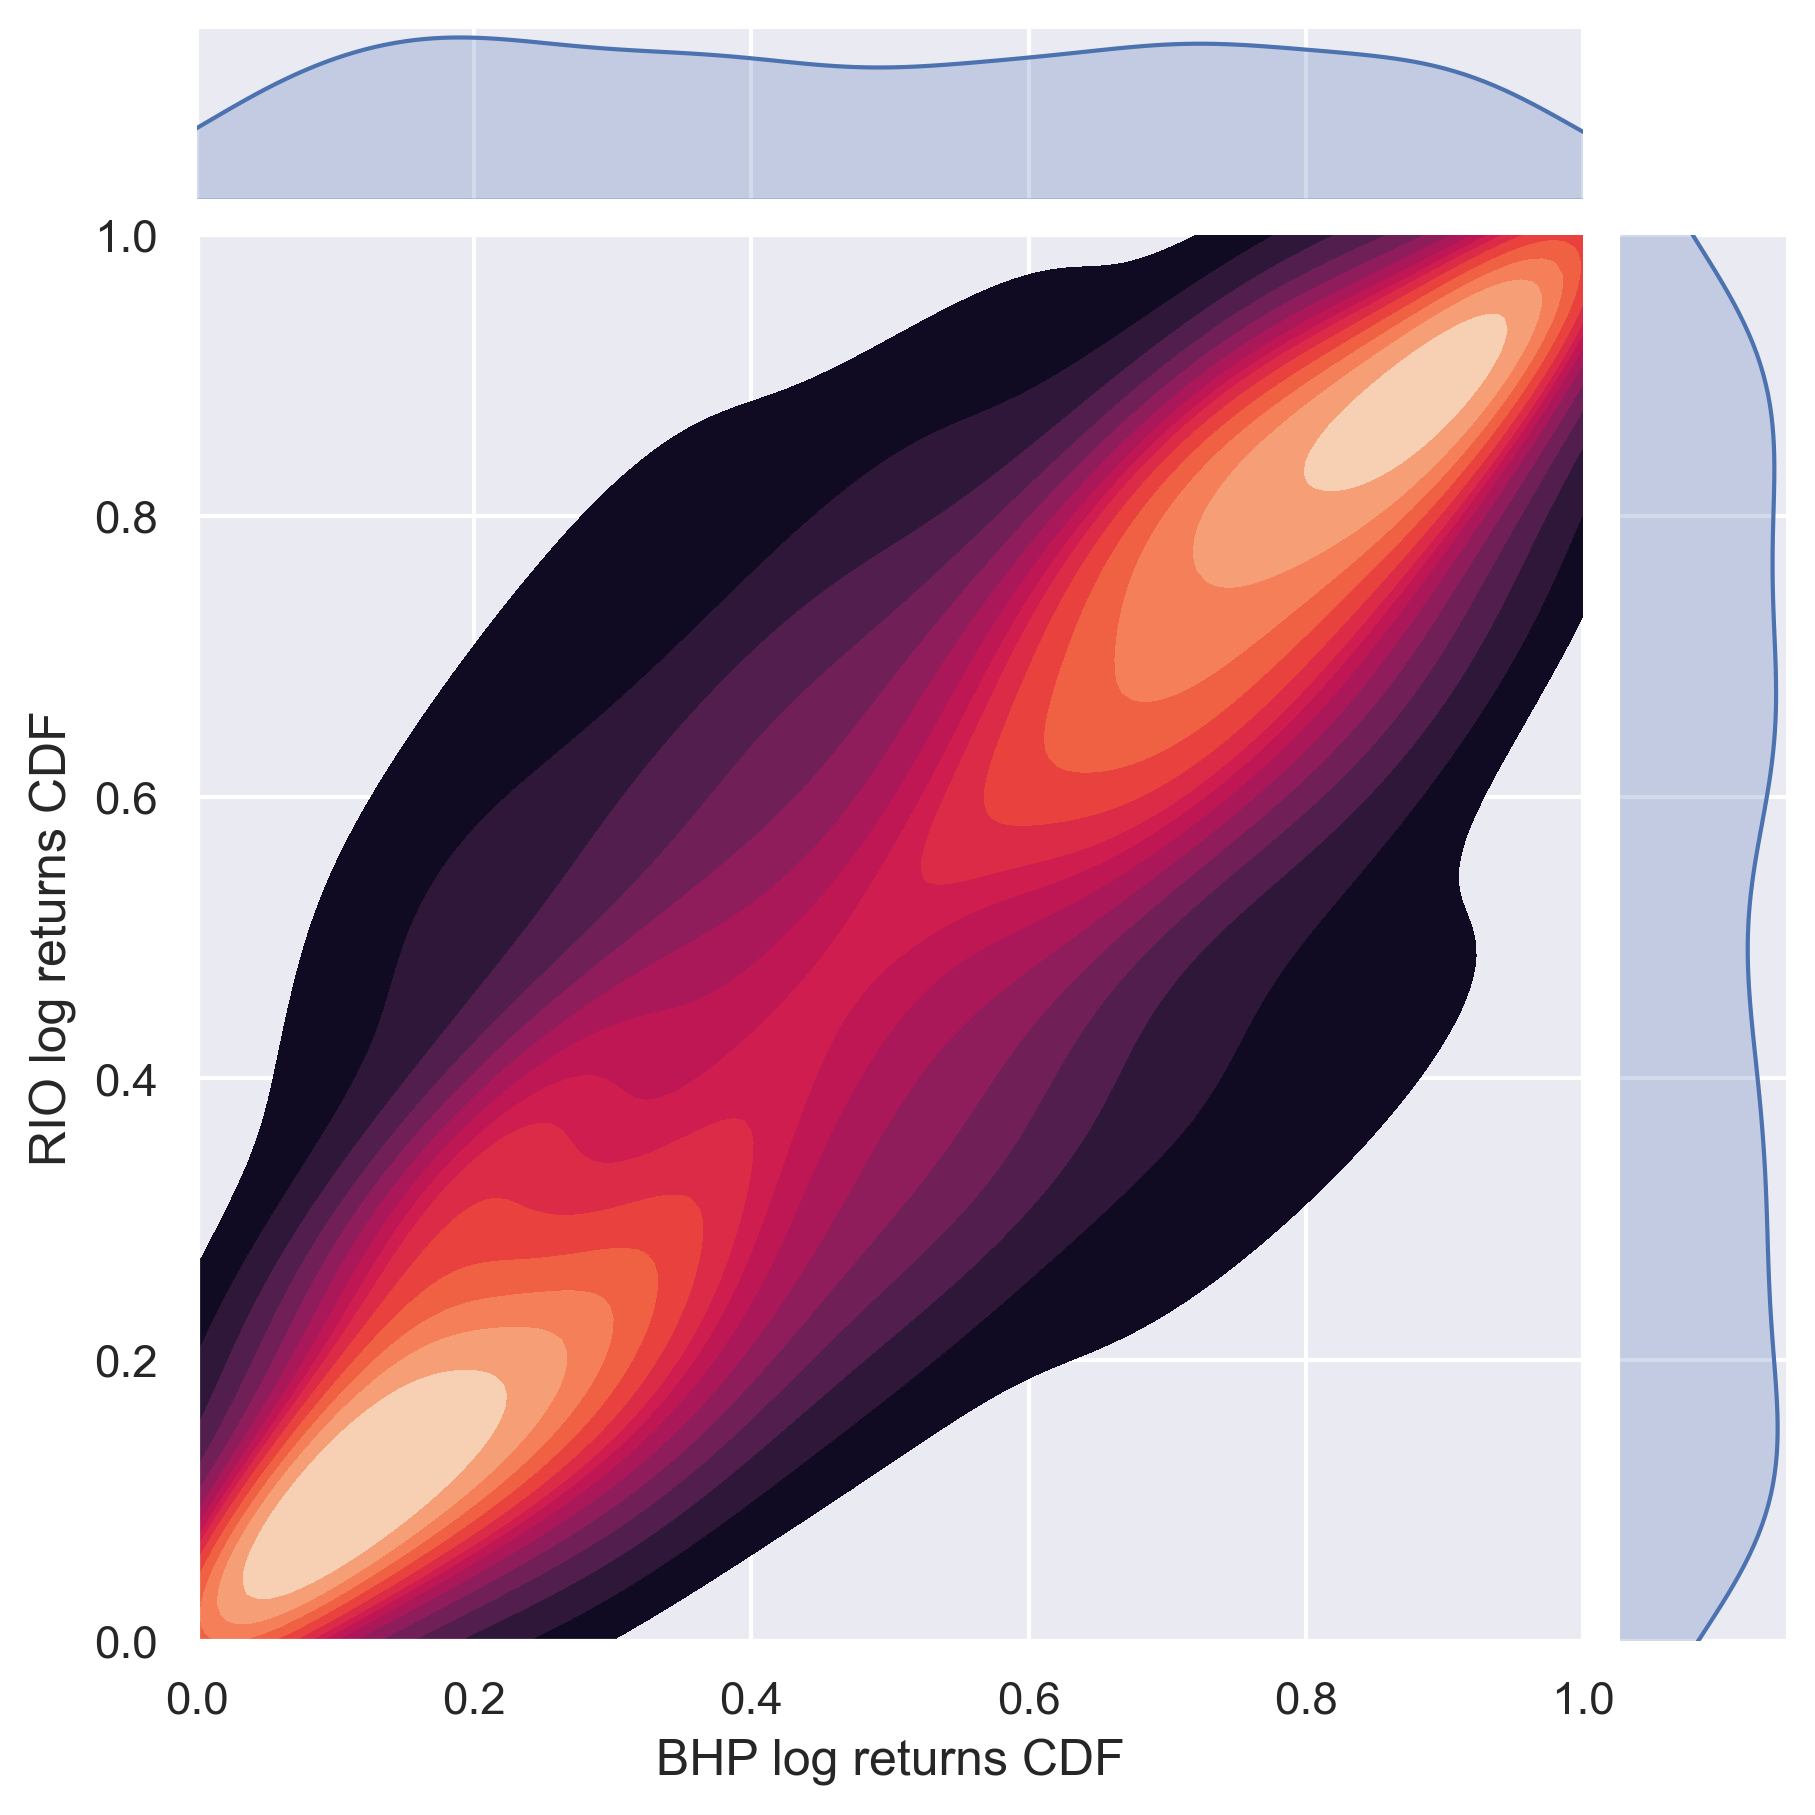

In [300]:
simul = copu.simulate(n=1000)
h = sns.jointplot(x=simul.T[0], y=simul.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels("BHP log returns CDF", "RIO log returns CDF")

In [296]:
copList

[<BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.bb6: 8>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.gumbel: 4>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.frank: 5>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.frank: 5>,
 <BicopFamily.frank: 5>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <BicopFamily.bb8: 10>,
 <B

In [307]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

x = (np.log(S1) - np.log(S1.shift(1)))[1:]
y = (np.log(S2) - np.log(S2.shift(1)))[1:]
# cumulative distribution function (marginal distributions)
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
# u, v = [ecdf_x(a) for a in x], [ecdf_y(a) for a in y]

# S1 is the first column of u, S2 is the second
u = np.array([[ecdf_x(a) for a in x], [ecdf_y(a) for a in y]]).T

u, pv.to_pseudo_obs(xy)

(array([[0.69498222, 0.92493086],
        [0.32872382, 0.24417226],
        [0.4227578 , 0.14105097],
        ...,
        [0.69221652, 0.88897669],
        [0.14974318, 0.32990913],
        [0.39747136, 0.34136705]]),
 array([[0.69470774, 0.92456556],
        [0.328594  , 0.24407583],
        [0.42259084, 0.14099526],
        ...,
        [0.69194313, 0.88862559],
        [0.14968404, 0.32977883],
        [0.39731438, 0.34123223]]))

In [306]:
xy = np.array([[a for a in x], [a for a in y]]).T
xy

array([[ 0.00815901,  0.02381931],
       [-0.00631083, -0.01015969],
       [-0.00264133, -0.01691841],
       ...,
       [ 0.00798362,  0.02032401],
       [-0.01603149, -0.00613082],
       [-0.00350033, -0.005739  ]])